In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import sys
sys.path.append('../input/keras-ssd/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation



In [4]:
img_height = 300
img_width = 480
img_channels = 3

intensity_mean = 127.5
intensity_range = 127.5

n_classes = 5
scales = [0.08, 0.16, 0.32, 0.64, 0.96]
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

In [5]:
K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

In [8]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


In [10]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

In [11]:
images_dir = '../input/self-driving-cars/images/'

train_labels_filename = '../input/self-driving-cars/labels_train.csv'
val_labels_filename   = '../input/self-driving-cars//labels_val.csv'
train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [12]:
batch_size = 16

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))


In [15]:
from tensorflow.keras import backend as K

predictor_sizes = [
    K.int_shape(model.get_layer('classes4').output)[1:3],
    K.int_shape(model.get_layer('classes5').output)[1:3],
    K.int_shape(model.get_layer('classes6').output)[1:3],
    K.int_shape(model.get_layer('classes7').output)[1:3]
]


In [17]:
import numpy as np

# Temporary fix for np.float removal in newer numpy versions
if not hasattr(np, 'float'):
    np.float = float


In [18]:
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                   img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

In [20]:
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='ssd7_weights.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch'  # save after each epoch
)


In [23]:
import tensorflow as tf

class CustomModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self, save_period_epochs=1, **kwargs):
        super().__init__(**kwargs)
        self.save_period_epochs = save_period_epochs
        self.epochs_since_last_save = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.save_period_epochs:
            self.epochs_since_last_save = 0
            super().on_epoch_end(epoch, logs)

# Usage example: save every 5 epochs
model_checkpoint = CustomModelCheckpoint(
    filepath='ssd7_weights.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_period_epochs=5
)


In [24]:
def train(model):
    initial_epoch   = 0
    final_epoch     = 20
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=final_epoch,
                                callbacks=callbacks,
                                validation_data=val_generator,
                                validation_steps=ceil(val_dataset_size/batch_size),
                                initial_epoch=initial_epoch)

    plt.figure(figsize=(20,12))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='upper right', prop={'size': 24})

    return model

In [25]:
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [26]:
batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: ../input/self-driving-cars/images/1478901524392001997.jpg

Ground truth boxes:

[[  1 115 158 135 176]
 [  1 135 158 147 171]
 [  1 148 156 164 168]
 [  1 223 146 252 171]]


In [27]:
y_pred = model.predict(batch_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


In [29]:
y_pred_decoded = decode_detections(y_pred * 266.,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[     2.       44.33  -1322.17  67737.18   7706.17  76765.52]
 [     2.       44.33  -2128.    69059.35   4256.    75443.35]
 [     2.       44.33 124358.91  65580.43 128873.09  74608.76]
 ...
 [     2.       44.33   3062.92  61266.91   7577.09  70295.25]
 [     2.       44.33    934.92  61266.91   5449.09  70295.25]
 [     1.       44.33 100503.32  33711.64 136616.67 105938.36]]


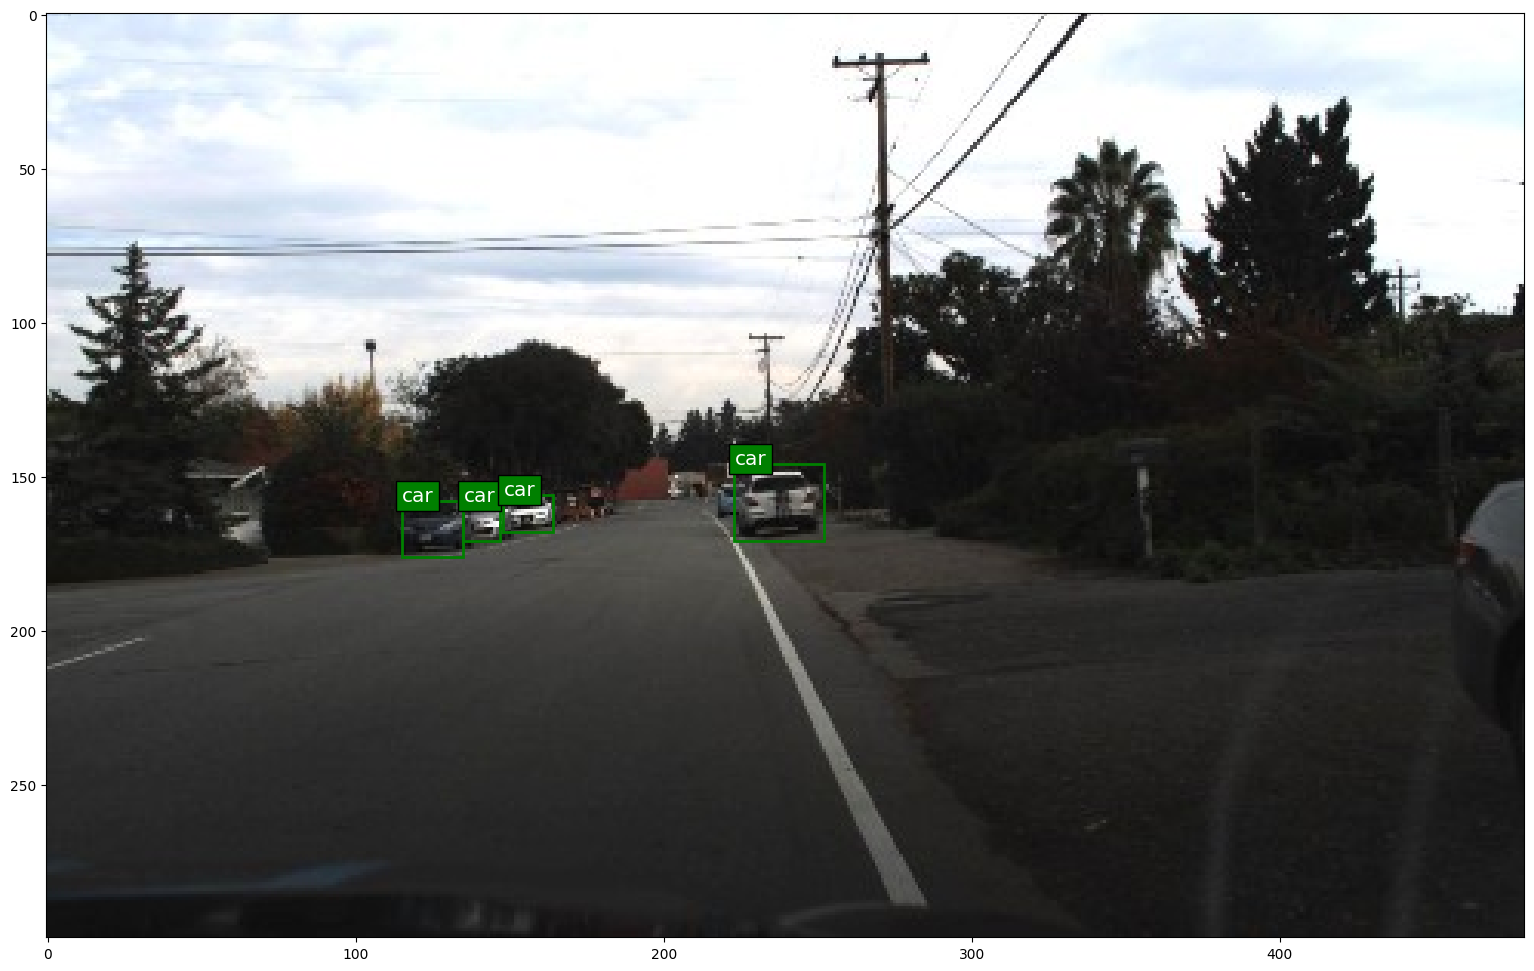

In [30]:
plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light']

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  

In [31]:
confidence_threshold = 0.5

for box in y_pred_decoded[i]:
    score = box[1]
    if score < confidence_threshold:
        continue
    xmin, ymin, xmax, ymax = box[-4], box[-3], box[-2], box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], score)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': color, 'alpha': 0.8})


In [32]:
gt_color = 'green'  # ground truth
pred_color = 'red'  # predictions


In [36]:
# Πραγματικές κλάσεις (ground truth)
y_true = [int(box[0]) for box in batch_labels[i]]

# Προβλεπόμενες κλάσεις (με confidence > 0.5)
confidence_threshold = 0.5
y_pred = [int(box[0]) for box in y_pred_decoded[i] if box[1] > confidence_threshold]

print("True classes:", y_true)
print("Predicted classes:", y_pred)


True classes: [1, 1, 1, 1]
Predicted classes: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


In [38]:
print("y_true sample:", y_true[:20])
print("y_pred sample:", y_pred[:20])


y_true sample: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
y_pred sample: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [39]:
import numpy as np
import PIL 
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
import warnings
warnings.simplefilter('ignore')
!pip install ultralytics 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

In [40]:
import ultralytics
from ultralytics import YOLO
yolo_model = YOLO('yolov8m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


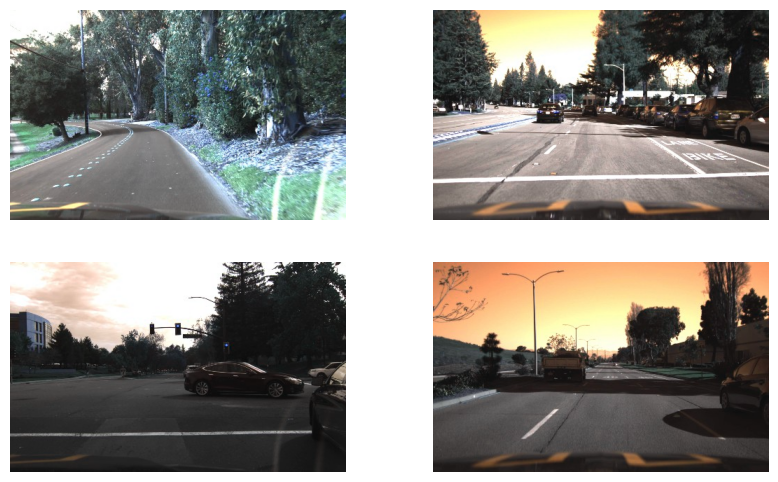

In [41]:
root_path = '/kaggle/input/self-driving-cars/images/*'
num_samples = 4
images_data = glob(root_path)
random_image = random.sample(images_data, num_samples)

plt.figure(figsize=(10,6))
for i in range(num_samples):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.imread(random_image[i]))
    plt.axis('off')

In [42]:
images = []
for i in range(num_samples):
    yolo_outputs = yolo_model.predict(random_image[i])
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        #print(f'In this image {len(box)} objects has been detected.')
        print(f'Object {j + 1} is: {labels}')
        print(f'Coordinates are: {coordinates}')
        print(f'Confidence is: {confidence}')
        print('-------')
        
    # Store the image in the 'images' list
    images.append(output.plot()[:, :, ::-1])


image 1/1 /kaggle/input/self-driving-cars/images/1478895890903221340.jpg: 416x640 1 car, 788.4ms
Speed: 9.3ms preprocess, 788.4ms inference, 16.5ms postprocess per image at shape (1, 3, 416, 640)
Object 1 is: car
Coordinates are: [1.6065673828125, 159.073486328125, 337.8945007324219, 295.9201965332031]
Confidence is: 0.46
-------

image 1/1 /kaggle/input/self-driving-cars/images/1479500160087571346.jpg: 416x640 14 cars, 668.1ms
Speed: 2.0ms preprocess, 668.1ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 640)
Object 1 is: car
Coordinates are: [430.2785339355469, 135.56309509277344, 479.7095031738281, 195.11692810058594]
Confidence is: 0.89
-------
Object 2 is: car
Coordinates are: [358.9649353027344, 123.67716979980469, 458.5583801269531, 184.7431182861328]
Confidence is: 0.87
-------
Object 3 is: car
Coordinates are: [147.1260223388672, 132.93235778808594, 187.47889709472656, 162.13937377929688]
Confidence is: 0.87
-------
Object 4 is: car
Coordinates are: [329.3644104



-------------------------------------- Images after object detection with YOLOV8 --------------------------------


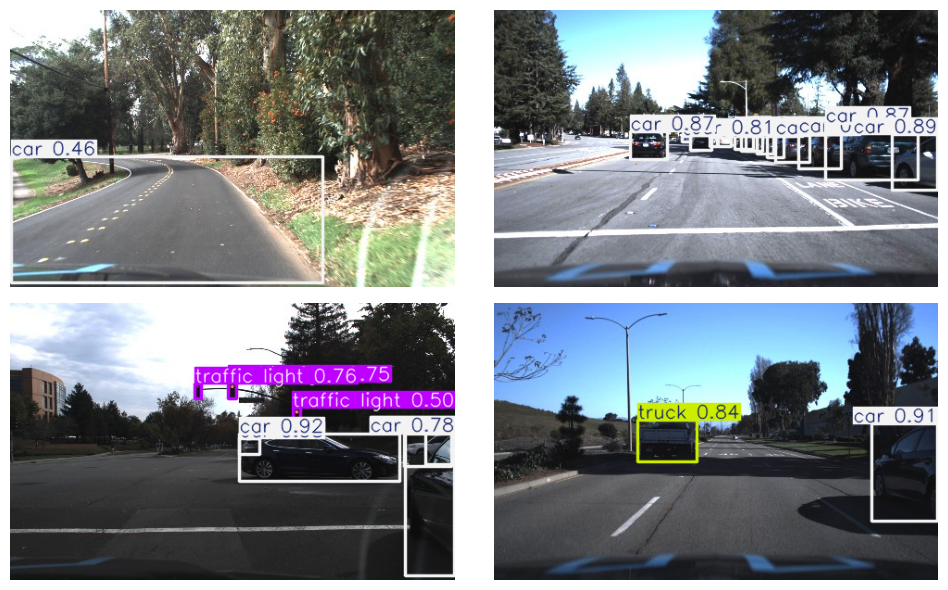

In [43]:
# plotting the images after object detection
print('\n\n-------------------------------------- Images after object detection with YOLOV8 --------------------------------')    

plt.figure(figsize=(10,6))
for i, img in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')    
plt.tight_layout()
plt.show()